# Proyek Kedua : Membuat Model Machine Learning dengan Data Time Series

Nama Lengkap : Muhammad Fadhil Abyansyah

Username : fadhil-abyansyah

Email : infofadhil29@gmail.com


---

In [69]:
# Import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense, LSTM
from sklearn.model_selection import train_test_split

In [70]:
# Membaca file CSV
df = pd.read_csv('delhi-weather.csv')
df.head()

,datetime_utc,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
0,19961101-11:00,Smoke,9.0,0,0,NaN,27.0,NaN,1010.0,0,0,30.0,0,0,5.0,280.0,West,NaN,NaN,7.4
1,19961101-12:00,Smoke,10.0,0,0,NaN,32.0,NaN,-9999.0,0,0,28.0,0,0,NaN,0.0,North,NaN,NaN,NaN
2,19961101-13:00,Smoke,11.0,0,0,NaN,44.0,NaN,-9999.0,0,0,24.0,0,0,NaN,0.0,North,NaN,NaN,NaN
3,19961101-14:00,Smoke,10.0,0,0,NaN,41.0,NaN,1010.0,0,0,24.0,0,0,2.0,0.0,North,NaN,NaN,NaN
4,19961101-16:00,Smoke,11.0,0,0,NaN,47.0,NaN,1011.0,0,0,23.0,0,0,1.2,0.0,North,NaN,NaN,0.0


In [71]:
# Menampilkan jumlah kolom dan baris
df.shape

(100990, 20)

In [72]:
# Menampilkan jumlah baris dan kolom, nama kolom dan tipe data, dan jumlah nilai non-null
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100990 entries, 0 to 100989
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   datetime_utc  100990 non-null  object 
 1    _conds       100918 non-null  object 
 2    _dewptm      100369 non-null  float64
 3    _fog         100990 non-null  int64  
 4    _hail        100990 non-null  int64  
 5    _heatindexm  29155 non-null   float64
 6    _hum         100233 non-null  float64
 7    _precipm     0 non-null       float64
 8    _pressurem   100758 non-null  float64
 9    _rain        100990 non-null  int64  
 10   _snow        100990 non-null  int64  
 11   _tempm       100317 non-null  float64
 12   _thunder     100990 non-null  int64  
 13   _tornado     100990 non-null  int64  
 14   _vism        96562 non-null   float64
 15   _wdird       86235 non-null   float64
 16   _wdire       86235 non-null   object 
 17   _wgustm      1072 non-null    float64
 18   _wi

In [73]:
# Menghitung jumlah nilai null dalam setiap kolom dari DataFrame
df.isnull().sum()

datetime_utc         0
 _conds             72
 _dewptm           621
 _fog                0
 _hail               0
 _heatindexm     71835
 _hum              757
 _precipm       100990
 _pressurem        232
 _rain               0
 _snow               0
 _tempm            673
 _thunder            0
 _tornado            0
 _vism            4428
 _wdird          14755
 _wdire          14755
 _wgustm         99918
 _windchillm    100411
 _wspdm           2358
dtype: int64

In [74]:
# Mengubah kolom 'datetime_utc' menjadi tipe data datetime dan menampilkan lima baris pertama:
df['datetime_utc']=pd.to_datetime(df['datetime_utc'])
df['datetime_utc'].head()

# Mengisi nilai null dalam kolom ' _tempm' dengan rata-rata dan mengganti nilai DataFrame dengan hanya dua kolom ('datetime_utc' dan ' _tempm'):
df[' _tempm'].fillna(df[' _tempm'].mean(), inplace=True)
df = df[['datetime_utc',' _tempm' ]]
df.head()

,datetime_utc,_tempm
0,1996-11-01 11:00:00,30.0
1,1996-11-01 12:00:00,28.0
2,1996-11-01 13:00:00,24.0
3,1996-11-01 14:00:00,24.0
4,1996-11-01 16:00:00,23.0


In [75]:
# Mengubah kolom datatime_utc menjadi date
delhi=df[['datetime_utc',' _tempm']].copy()
delhi['date'] = delhi['datetime_utc'].dt.date

# Membuat df baru bernama delhinew
delhinew=delhi.drop('datetime_utc',axis=1)
delhinew.set_index('date', inplace= True)
delhinew.head()

,_tempm
date,
1996-11-01,30.0
1996-11-01,28.0
1996-11-01,24.0
1996-11-01,24.0
1996-11-01,23.0


In [76]:
# Menampilkan jumlah baris dan kolom, nama kolom dan tipe data, dan jumlah nilai non-null dari delhinew
delhinew.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100990 entries, 1996-11-01 to 2017-04-24
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0    _tempm  100990 non-null  float64
dtypes: float64(1)
memory usage: 1.5+ MB


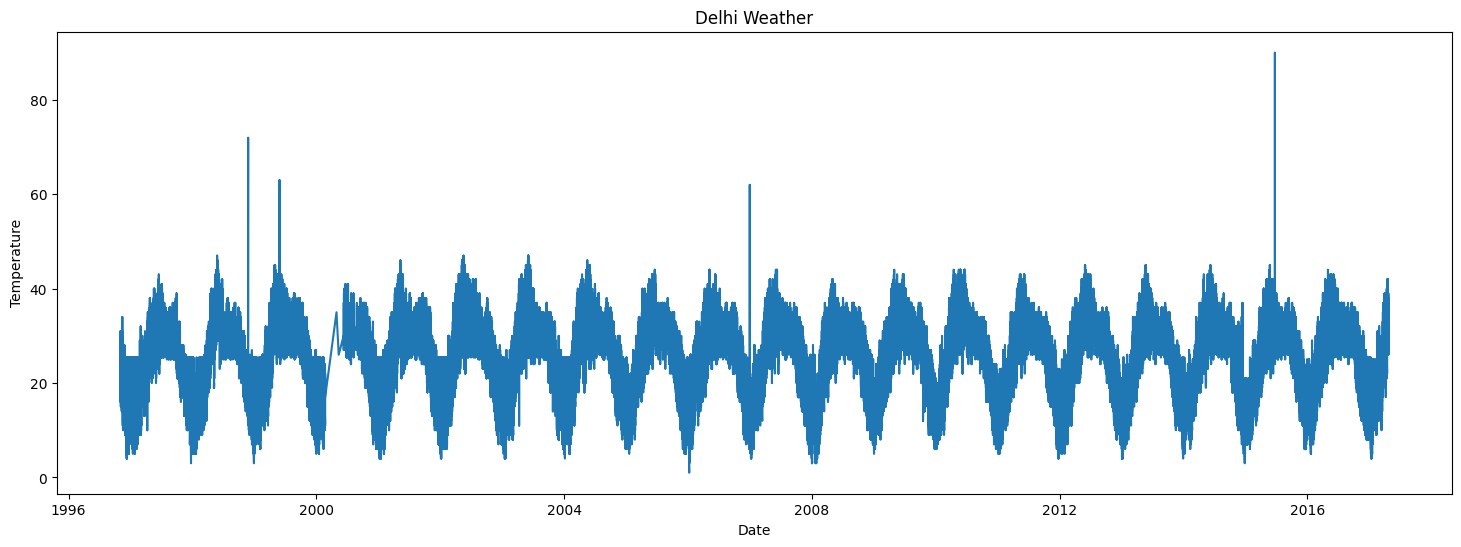

In [77]:
# Membuat plot dari data delhi weather
date = delhi['date'].values
temp = delhi[' _tempm'].values

plt.figure(figsize=(18,6))
plt.plot(delhinew)
plt.title('Delhi Weather')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.show()

In [78]:
# Menerima sebuah atribut yg telah dikonversi menjadi tipe numpy,lalu mengembalikan label dan atribut dari dataset dalam bentuk batch
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [79]:
# Split data dimana validation setnya 20% dari dataset
x_train, x_test, y_train, y_test = train_test_split(temp, date, test_size = 0.2, random_state = 0 , shuffle=False)

# Mengetahui ukuran x_train dan x_test
print(len(x_train), len(x_test))

80792 20198


In [80]:
# Model
data_x_train = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=5000)
data_x_test = windowed_dataset(x_test, window_size=60, batch_size=100, shuffle_buffer=5000)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

# Optimizer menggunakan Learning Rate
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [81]:
# Melihat nilai maksimum dan minimum dari kolom '_tempm' dalam DataFrame
max = df[' _tempm'].max()
print('Max value: ' )
print(max)
min = df[' _tempm'].min()
print('Min Value: ')
print(min)

Max value: 
90.0
Min Value: 
1.0


In [82]:
# Menghitung range data (10% dari range) dan menyimpannya dalam variabel x
x = (max - min) * (10 / 100)
print(x)

8.9


In [83]:
# Callback untuk menghentikan pelatihan model jika MAE (Mean Absolute Error) < 10% dari skala data
class CallBack(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')< x):
      self.model.stop_training = True
      print('\nUntuk Epoch', epoch, ' pelatihan dihentikan.''\nKarena MAE dari model telah mencapai < 10% dari skala data')
callbacks = CallBack()

In [84]:
# Melakukan pelatihan model dengan data pelatihan dan data validasi
tf.keras.backend.set_floatx('float64')
history = model.fit(data_x_train,
                    epochs=100,
                    validation_data=data_x_test,
                    callbacks=[callbacks])

Epoch 1/100
808/808 [==============================] - 171s 207ms/step - loss: 45.4588 - mae: 45.9545 - val_loss: 19.4549 - val_mae: 19.9491
Epoch 2/100
808/808 [==============================] - 164s 201ms/step - loss: 13.5400 - mae: 14.0315 - val_loss: 8.8155 - val_mae: 9.3033
Epoch 3/100
808/808 [==============================] - ETA: 0s - loss: 7.7054 - mae: 8.1904
Untuk Epoch 2  pelatihan dihentikan.
Karena MAE dari model telah mencapai < 10% dari skala data
808/808 [==============================] - 164s 203ms/step - loss: 7.7054 - mae: 8.1904 - val_loss: 7.4251 - val_mae: 7.9089


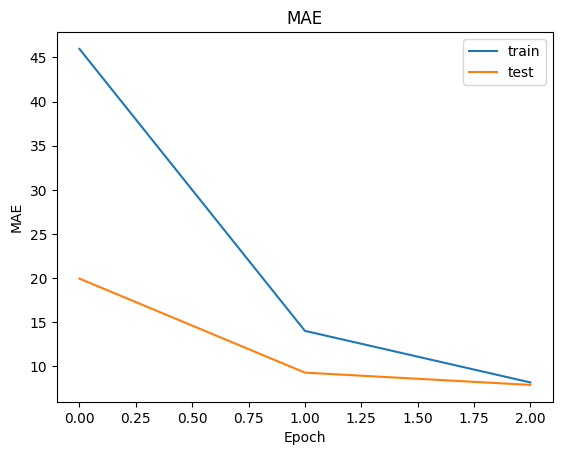

In [85]:
# Menampilkan plot untuk MAE
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

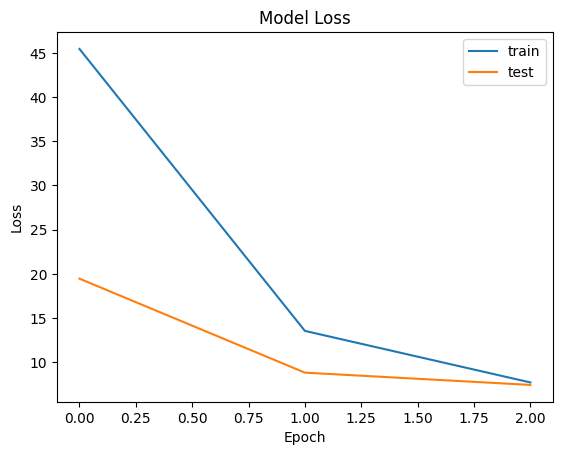

In [86]:
# Menampilkan plot untuk loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()